# MNIST Classifier Project - Sasmit Datta

### Importing Packages

In [1]:
#Importing the necessary libraries to do this project
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Data Transformation

In [3]:
#Importing data in the form of pandas dataframe
df_training_set=pd.read_csv('digit-recognizer/train.csv')
df_testing_set=pd.read_csv('digit-recognizer/test.csv')

In [4]:
df_training_set.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_testing_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Transforming the labels to numpy arrays
Y_train=np.array(df_training_set['label'])
Y_train

array([1, 0, 1, ..., 7, 6, 9])

In [7]:
#Transforming the training and testing data to numpy arrays
X_train=np.array(df_training_set.loc[:,'pixel0':'pixel783'])/255
X_test=np.array(df_testing_set.loc[:,'pixel0':'pixel783'])/255
X_train.shape

(42000, 784)

In [8]:
X_test.shape

(28000, 784)

Label: 9


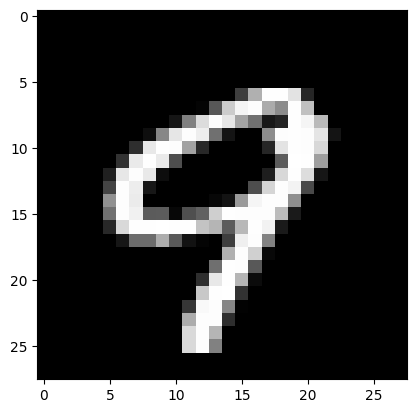

In [9]:
#Function to view the images and its labels
def view(index):
    global X_train,Y_train
    image=(X_train*255)[index]
    label=Y_train[index]
    print(f'Label: {label}')
    image=image.reshape(28,28)
    plt.imshow(image,cmap='gray')
    plt.show
    
view(100)

### Neural Network Framework

In [10]:
#Class for creating layers

class Layer_Dense:
    
    def __init__(self,n_inputs,n_neuron):
        #Initializing random weights of the neurons
        self.weights=0.01*np.random.randn(n_inputs,n_neuron)
        #Initializing random biases of the neurons
        self.biases=np.zeros((1,n_neuron))
    
    #Forward Pass
    def forward(self,inputs):
        self.inputs=np.array(inputs)
        #No need to transpose weights as it already is upon initialisation.
        self.output=np.dot(inputs,self.weights)+self.biases 

    def backward(self,dvalues):
        #Gradient of parameters
        self.dweights=np.dot(self.inputs.T,dvalues)
        self.dbiases=np.sum(dvalues,axis=0,keepdims=True)
        #Gradient on values
        self.dinputs=np.dot(dvalues, self.weights.T)

In [11]:
# Class for ReLU activation
class Activation_ReLU:
    
    def forward(self,inputs):
        self.inputs=inputs
        self.output=np.maximum(0,inputs)

    def backward(self,dvalues):
        #Since we need to modify original, we create a copy
        self.dinputs=dvalues.copy()
        #Zero gradients where values are less than zero
        self.dinputs[self.inputs<=0]=0

In [12]:
# Class for Softmax activation
class Activation_Softmax:
    def forward(self,inputs):
        #Remember input values
        self.inputs=inputs
        #Subtracting max of each row from the values of each row before exponentiating so that the output doesn't explode.
        exp_values=np.exp(inputs-np.max(inputs,axis=1,keepdims=True)) 
        probabilites=exp_values/np.sum(exp_values,axis=1,keepdims=True)
        self.output=probabilites

In [13]:
class Loss_CategoricalLossEntropy:
    
    def forward(self,Y_pred,Y_train):
        # Number of samples in a batch
        samples = len(Y_pred)
        #Clip values so that we don't have to deal with zeroes
        Y_pred_clipped=np.clip(Y_pred,1e-7,1-1e-7)
        #Get the loss
        confidences=Y_pred_clipped[range(samples),Y_train]
        #Losses
        negative_log=-np.log(confidences)
        return negative_log
  
    def calculate(self,Y_pred,Y_train):
        sample_losses=self.forward(Y_pred,Y_train)
        loss=np.mean(sample_losses)
        return loss

In [14]:
# Softmax classifier combined  with Loss class

class Activation_Softmax_Loss_CategoricalCrossEntropy:
    
    #Creates Softmax and Loss objects
    def __init__(self):
        self.activation=Activation_Softmax()
        self.loss=Loss_CategoricalLossEntropy()
    
    #Returns loss value of the joint operation
    def forward(self,inputs,Y_train):
        #Performs softmax
        self.activation.forward(inputs)
        #Output of softmax
        self.output=self.activation.output
        #Calculate and return loss
        return self.loss.calculate(self.output,Y_train)

    def backward(self,dvalues,Y_train):
        #Number of samples
        samples=len(dvalues)
        self.dinputs=dvalues.copy()
        
        #Calculating gradient
        self.dinputs[range(samples),Y_train]-=1
        #Normalizing gradient
        self.dinputs=self.dinputs/samples

In [15]:
#Class for SGD

class Optimizer_SGD:
    
    #Initialize optimizer
    def __init__(self,learning_rate=1):
        self.learning_rate=learning_rate
    
    def update_params(self,layer):
        layer.weights += -self.learning_rate*layer.dweights
        layer.biases += -self.learning_rate*layer.dbiases

### Creating the Model

In [19]:
dense1=Layer_Dense(784,10)
activation1=Activation_ReLU()

dense2=Layer_Dense(10,10)
loss_activation=Activation_Softmax_Loss_CategoricalCrossEntropy()

In [20]:
#We are taking learning rate as 0.1
optimizer=Optimizer_SGD(0.1)

### Training

In [21]:
#Function to train our model
#Argument is the number of epochs model will train
#It returns the final accuracy and loss of the model

def train(epochs):

    global X_train,Y_train

    for epoch in range(epochs):

        #Forward Pass
        dense1.forward(X_train)
        activation1.forward(dense1.output) 
  
        dense2.forward(activation1.output)
        loss=loss_activation.forward(dense2.output,Y_train)

        #Figure out the accuracy
        predictions=np.argmax(loss_activation.output,axis=1)
        accuracy=np.mean(predictions==Y_train)

        #Print loss and accuracy
        if not epoch % 10:
            print(f'epoch: {epoch}, '+f'loss: {loss:.3f}, '+f'accuracy: {accuracy*100:.3f}%')

        #Backward Pass
        
        loss_activation.backward(loss_activation.output,Y_train)
        dense2.backward(loss_activation.dinputs)

        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)

        #Update parameters
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        
    return accuracy,loss



In [23]:
#Training the model 250 times first
acc1,loss1=train(250)

epoch: 0, loss: 2.037, accuracy: 35.402%
epoch: 10, loss: 1.865, accuracy: 37.952%
epoch: 20, loss: 1.673, accuracy: 42.638%
epoch: 30, loss: 1.494, accuracy: 51.262%
epoch: 40, loss: 1.333, accuracy: 60.938%
epoch: 50, loss: 1.189, accuracy: 67.264%
epoch: 60, loss: 1.064, accuracy: 71.190%
epoch: 70, loss: 0.962, accuracy: 74.193%
epoch: 80, loss: 0.879, accuracy: 76.405%
epoch: 90, loss: 0.812, accuracy: 78.240%
epoch: 100, loss: 0.757, accuracy: 79.729%
epoch: 110, loss: 0.712, accuracy: 80.893%
epoch: 120, loss: 0.674, accuracy: 81.905%
epoch: 130, loss: 0.641, accuracy: 82.738%
epoch: 140, loss: 0.614, accuracy: 83.445%
epoch: 150, loss: 0.590, accuracy: 84.052%
epoch: 160, loss: 0.569, accuracy: 84.595%
epoch: 170, loss: 0.551, accuracy: 85.098%
epoch: 180, loss: 0.535, accuracy: 85.545%
epoch: 190, loss: 0.520, accuracy: 85.879%
epoch: 200, loss: 0.507, accuracy: 86.245%
epoch: 210, loss: 0.496, accuracy: 86.524%
epoch: 220, loss: 0.485, accuracy: 86.824%
epoch: 230, loss: 0.47

In [24]:
#Checking the accuracy and loss
print(acc1)
print(loss1)

0.8741190476190476
0.4590711324642541


In [25]:
#Training the model another 251 times
acc2,loss2=train(251)

epoch: 0, loss: 0.458, accuracy: 87.429%
epoch: 10, loss: 0.451, accuracy: 87.571%
epoch: 20, loss: 0.444, accuracy: 87.721%
epoch: 30, loss: 0.437, accuracy: 87.869%
epoch: 40, loss: 0.431, accuracy: 87.990%
epoch: 50, loss: 0.426, accuracy: 88.140%
epoch: 60, loss: 0.420, accuracy: 88.229%
epoch: 70, loss: 0.415, accuracy: 88.362%
epoch: 80, loss: 0.411, accuracy: 88.467%
epoch: 90, loss: 0.406, accuracy: 88.574%
epoch: 100, loss: 0.402, accuracy: 88.690%
epoch: 110, loss: 0.398, accuracy: 88.795%
epoch: 120, loss: 0.394, accuracy: 88.912%
epoch: 130, loss: 0.391, accuracy: 89.019%
epoch: 140, loss: 0.387, accuracy: 89.098%
epoch: 150, loss: 0.384, accuracy: 89.198%
epoch: 160, loss: 0.381, accuracy: 89.264%
epoch: 170, loss: 0.378, accuracy: 89.326%
epoch: 180, loss: 0.375, accuracy: 89.410%
epoch: 190, loss: 0.372, accuracy: 89.490%
epoch: 200, loss: 0.369, accuracy: 89.581%
epoch: 210, loss: 0.367, accuracy: 89.640%
epoch: 220, loss: 0.364, accuracy: 89.695%
epoch: 230, loss: 0.36

In [26]:
#Checking the accuracy and loss
print(acc2)
print(loss2)

0.8985
0.3571328207799805


### Testing

In [27]:
#Defining a softmax activation function object separately
activation2=Activation_Softmax()

In [28]:
#Function to test the trained model
#It takes in the index of our testing sample, runs it through the trained model and churns out the model's prediction along with an image
def test(index):
    global X_test
    
    #Forward Pass with the optimized weights and biases
    dense1.forward(X_test[index])
    activation1.forward(dense1.output) 
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    
    #Getting the prediction
    prediction=np.argmax(activation2.output)
    
    #printing the prediction
    print('Prediction: ',prediction)
    
    #Displaying the image
    image=(X_test*255)[index]
    image=image.reshape(28,28)
    plt.imshow(image,cmap='gray')
    plt.show

#### A couple of tests (10)

Prediction:  1


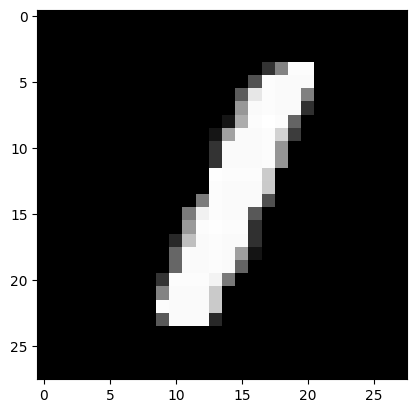

In [29]:
test(69)

Prediction:  9


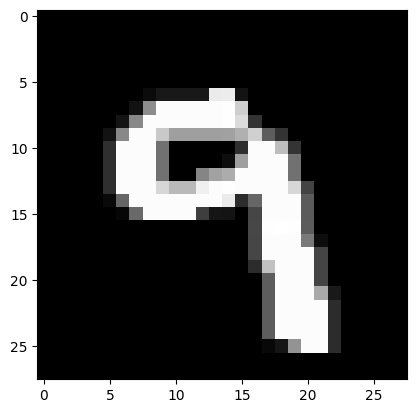

In [30]:
test(420)

Prediction:  7


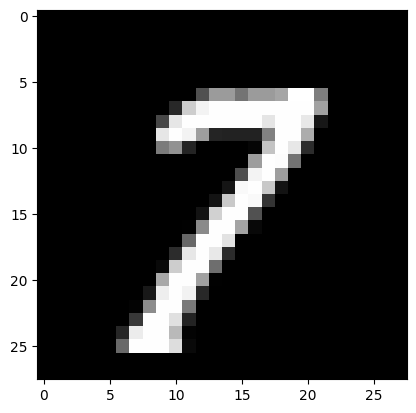

In [31]:
test(6969)

Prediction:  2


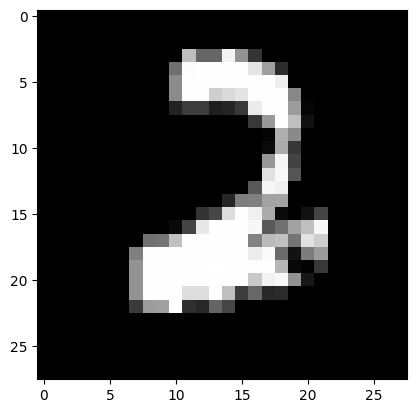

In [32]:
test(4269)

Prediction:  2


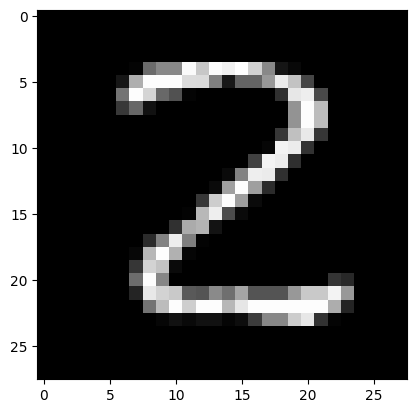

In [33]:
test(90)

Prediction:  6


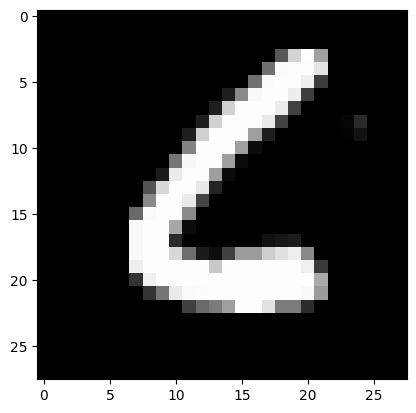

In [34]:
test(198)

Prediction:  7


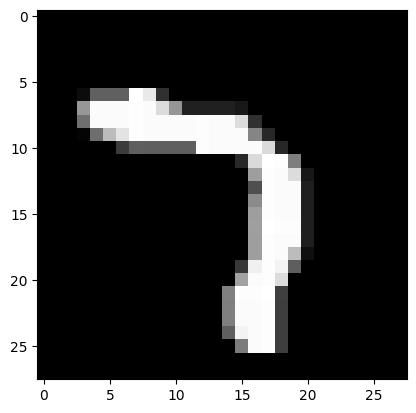

In [35]:
test(45)

Prediction:  5


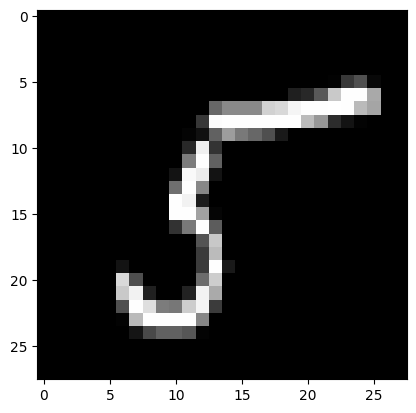

In [36]:
test(23)

Prediction:  9


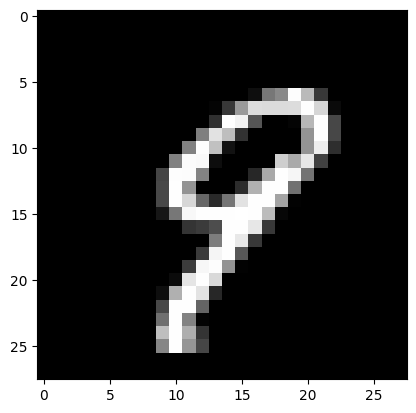

In [37]:
test(67)

Prediction:  2


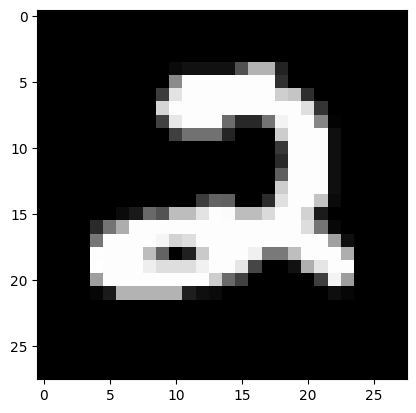

In [38]:
test(0)